## Import packages

In [1]:
import Utils
import QuantLib as ql
import HestonFactory as Heston
import BlackScholesFactory as BS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stat

## Configuration global data

In [2]:
AsOfDate = ql.Date(15,10,2018)
DayCount = ql.Actual365Fixed()
Calendar = ql.UnitedStates()
GlobalData = {'AsOfDate':AsOfDate,'DayCount':DayCount,'Calendar':Calendar}

## 1 - BS Simulation

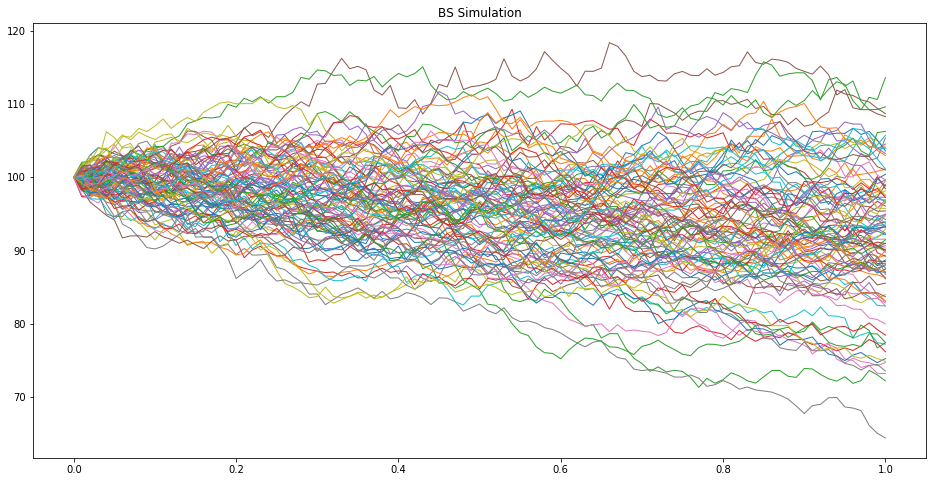

In [3]:
BSPathGenerator = BS.BlackScholesPathGenerator(r=0.1,q=0.005,s0=100,sigma=0.1,length=1,timestep=100,brownianBridge=False)
NumPaths = 100
time, paths = Utils.GeneratePaths(NumPaths,GlobalData,BSPathGenerator)

plt.figure(1,figsize=(16,8))
for i in range(NumPaths):
    plt.plot(time, paths[i, :], lw=1, alpha=1)
plt.title("BS Simulation")
plt.show()

## 2 - Heston Simulation

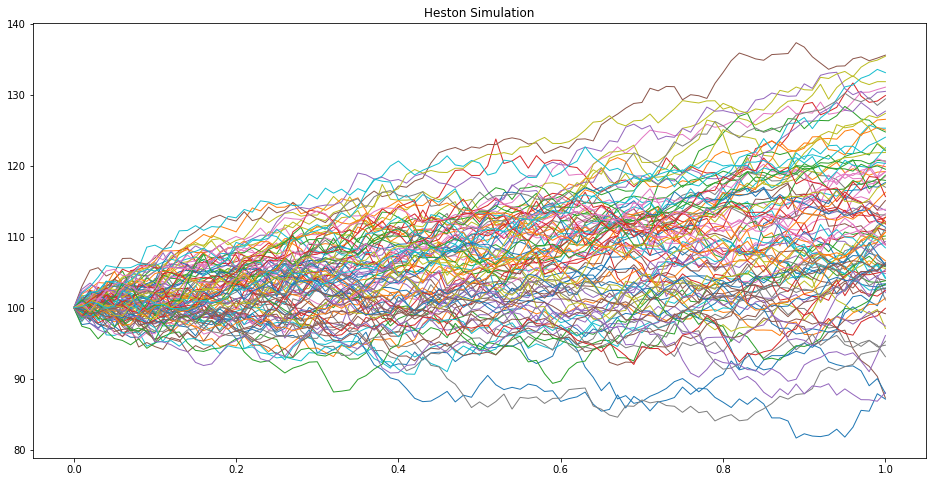

In [4]:
timestep = 100
length = 1
HestonPathGenerator = Heston.HestonPathGenerator(r=0.1,q=0.005,s0=100,v0=0.01,kappa=0.5,theta=0.01,sigma=0.05,rho=-0.5,
                                                 timeGrid=[n/timestep*length for n in range(timestep+1)],brownianBridge=False)
NumPaths = 100
time, paths = Utils.GeneratePaths(NumPaths,GlobalData,HestonPathGenerator)

plt.figure(1,figsize=(16,8))
for i in range(NumPaths):
    plt.plot(time, paths[i, :], lw=1, alpha=1)
plt.title("Heston Simulation")
plt.show()

## 3 - Model Backtest: Hedging Vanilla European Option with BS in BS world 

In [5]:
# INSTRUMENT1D CONFIG #
MaturityDate = ql.Date(15,10,2019) 
K = 100
Type = ql.Option.Put
Payoff = ql.PlainVanillaPayoff(Type, K)
Exercise = ql.EuropeanExercise(MaturityDate)
EuropeanOption = ql.VanillaOption(Payoff, Exercise)
    
# PRICING ENGINE CONFIG #
sigmaBS = 0.1
BS_PricingEngine = BS.BlackScholesAnalyticEngineFactory(r=0.01,q=0,s0=100,sigma=sigmaBS)
    
# HEDGING ENGINE CONFIG #
HedgingStepDays = 1
BS_HedgingEngine = BS.BlackScholesAnalyticEngineFactory(r=0.01,q=0,s0=100,sigma=sigmaBS)
    
# PATH CONFIG # 
BSPathGenerator = BS.BlackScholesPathGenerator(r=0.1,q=0,s0=100,sigma=sigmaBS,
                                               length=DayCount.yearFraction(AsOfDate,MaturityDate),
                                               timestep=int((MaturityDate-AsOfDate)/HedgingStepDays),brownianBridge=False)

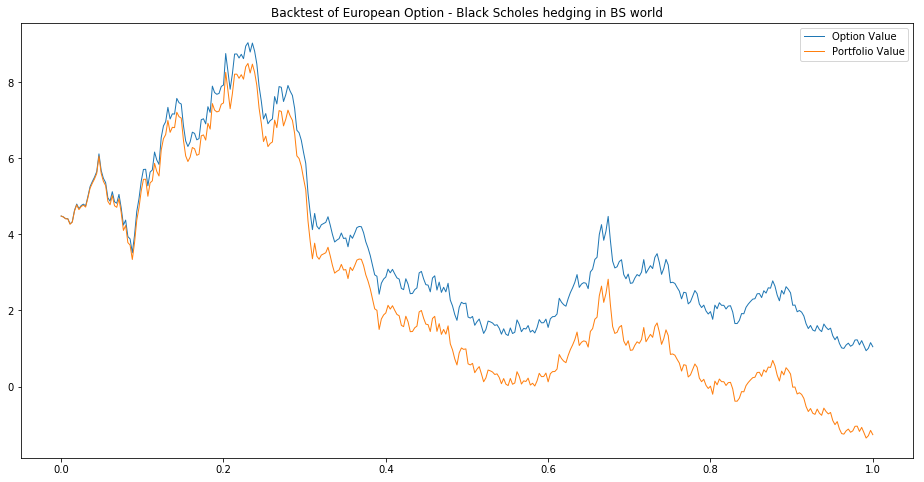

In [6]:
# BACKTEST COMPUTATION #
TradingMargin = 0
time, path = Utils.BacktestDeltaHedge1DWithRateDivConstant(GlobalData,BSPathGenerator,EuropeanOption,
                                                            BS_PricingEngine,BS_HedgingEngine,
                                                            HedgingStepDays,Margin=TradingMargin)

# GRAPHIC PLOT #
plt.figure(1,figsize=(16,8))
plt.plot(time, path[0, :], label='Option Value', lw=1, alpha=1)
plt.plot(time, path[1, :], label='Portfolio Value', lw=1, alpha=1)
plt.title("Backtest of European Option - Black Scholes hedging in BS world")
plt.legend()
plt.show()

## 4 - Model Backtest: Hedging Vanilla European Option with BS in Heston world 

In [7]:
# INSTRUMENT1D CONFIG #
MaturityDate = ql.Date(15,10,2019) 
K = 100
Type = ql.Option.Put
Payoff = ql.PlainVanillaPayoff(Type, K)
Exercise = ql.EuropeanExercise(MaturityDate)
EuropeanOption = ql.VanillaOption(Payoff, Exercise)
    
# PRICING ENGINE CONFIG #
HestonEngine = Heston.HestonAnalyticEngineFactory(r=0.01,q=0.005,s0=100,v0=0.01,kappa=0.5,theta=0.01,sigma=0.05,rho=-0.5,
                                                  relTolerance=0.01,maxEval=10000)
    
# HEDGING ENGINE CONFIG #
HedgingStepDays = 1
sigmaBS = 0.1
BlackScholesEngine = BS.BlackScholesAnalyticEngineFactory(r=0.01,q=0.005,s0=100,sigma=sigmaBS)
    
# PATH CONFIG # 
timestep = int((MaturityDate-AsOfDate)/HedgingStepDays)
length = DayCount.yearFraction(AsOfDate,MaturityDate)
HestonPathGenerator = Heston.HestonPathGenerator(r=0.1,q=0.005,s0=100,v0=0.01,kappa=0.5,theta=0.01,sigma=0.05,rho=-0.5,
                                                 timeGrid=[n/timestep*length for n in range(timestep+1)],brownianBridge=False)

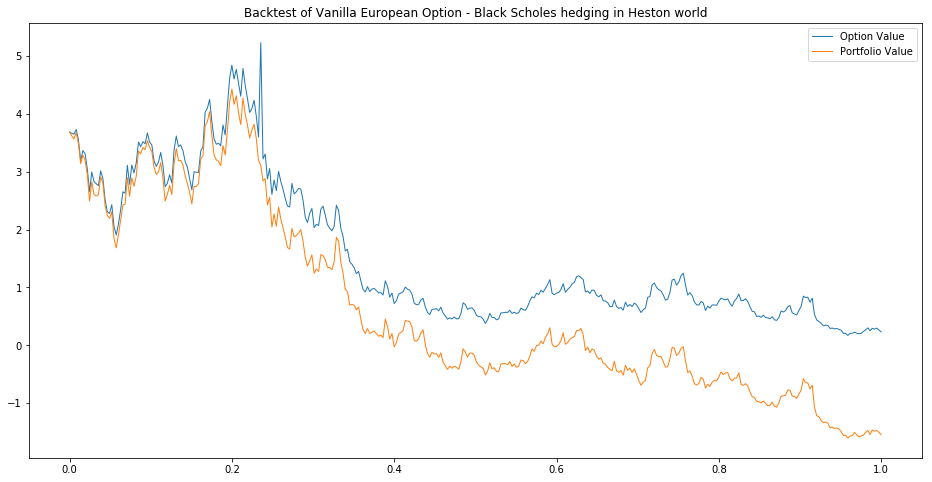

In [8]:
# BACKTEST COMPUTATION #
time, path = Utils.BacktestDeltaHedge1DWithRateDivConstant(GlobalData,HestonPathGenerator,EuropeanOption,
                                                            HestonEngine,BlackScholesEngine,HedgingStepDays)

# GRAPHIC PLOT #
plt.figure(1,figsize=(16,8))
plt.plot(time, path[0, :], label='Option Value', lw=1, alpha=1)
plt.plot(time, path[1, :], label='Portfolio Value', lw=1, alpha=1)
plt.title("Backtest of Vanilla European Option - Black Scholes hedging in Heston world")
plt.legend()
plt.show()

## 5 - Backtests - P&L distribution analysis

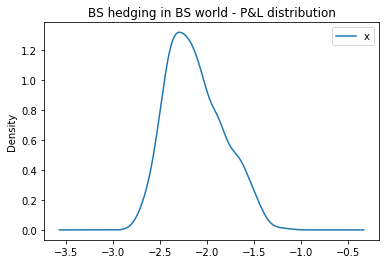

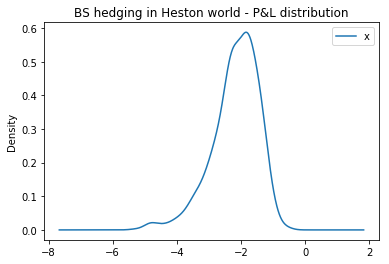

In [9]:
n = 1000
PL_BS_BS = np.zeros(n)
for i in range(n):
    time, path = Utils.BacktestDeltaHedge1DWithRateDivConstant(GlobalData,BSPathGenerator,EuropeanOption,
                                                            BS_PricingEngine,BS_HedgingEngine,
                                                            HedgingStepDays)
    PL_BS_BS[i]=path[1,len(path[0])-1]-path[0,len(path[0])-1]
df1 = pd.DataFrame({'x':PL_BS_BS})
ax = df1.plot.kde(title="BS hedging in BS world - P&L distribution")

PL_BS_Heston = np.zeros(n)
for i in range(n):
    time, path = Utils.BacktestDeltaHedge1DWithRateDivConstant(GlobalData,HestonPathGenerator,EuropeanOption,
                                                            HestonEngine,BlackScholesEngine,HedgingStepDays)
    PL_BS_Heston[i]=path[1,len(path[0])-1]-path[0,len(path[0])-1]
df2 = pd.DataFrame({'x':PL_BS_Heston})
ax2 = df2.plot.kde(title="BS hedging in Heston world - P&L distribution")

In [10]:
print('\nP&L analysis : BS hedging in BS world\n')
describ1 = stat.describe(df1)
print('min = ' + str(describ1.minmax[0][0]))
print('max = ' + str(describ1.minmax[1][0]))
print('mean = ' + str(describ1.mean[0]))
print('var = ' + str(describ1.variance[0]))
print('skew = ' + str(describ1.skewness[0]))
print('kurtosis = ' + str(describ1.kurtosis[0]))
describ2 = stat.describe(df2)
print('\n\nP&L analysis : BS hedging in Heston world\n')
print('min = ' + str(describ2.minmax[0][0]))
print('max = ' + str(describ2.minmax[1][0]))
print('mean = ' + str(describ2.mean[0]))
print('var = ' + str(describ2.variance[0]))
print('skew = ' + str(describ2.skewness[0]))
print('kurtosis = ' + str(describ2.kurtosis[0]) + '\n')


P&L analysis : BS hedging in BS world

min = -2.763769912897287
max = -1.1432866335896976
mean = -2.12856254813357
var = 0.08944707300727327
skew = 0.4453664816825243
kurtosis = -0.4150549897028122


P&L analysis : BS hedging in Heston world

min = -5.294167466026043
max = -0.5494886127050789
mean = -2.1806651936540007
var = 0.5389608399947312
skew = -0.9851781652516147
kurtosis = 1.426890572269035

